# Hypothesis Testing - Cumulative Lab

## Introduction

In this cumulative lab, you will use pandas to clean up a dataset and perform some EDA, then perform statistical tests and interpret their results in order to answer some business questions.

## Objectives

You will be able to:

* Practice using a data dictionary
* Practice using pandas to prepare data for statistical analysis
* Practice identifying an appropriate statistical test for a given question
* Practice defining the null and alternative hypotheses
* Practice executing statistical tests and interpreting their results

## Your Task: Analyzing Health Trends

![tissues and tea mug](images/sick_day.jpg)

Photo by <a href="https://unsplash.com/@kellysikkema?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Kelly Sikkema</a> on <a href="/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business Understanding

Flatiron Health Insurance (FHI) is a growing private healthcare insurance provider founded on the premise that using data and analytics can improve the health insurance industry by providing better care and offerings to its patients. Every year, the Center for Disease Control (CDC) conducts surveys to understand the latest demographic, health, and fitness trends. You have been tasked with analyzing the recently published results of the 2017-2018 survey and providing your recommendations back to the Chief Analytics Officer and Chief Marketing Officer. You have been assigned the task of taking a first look at the data and beginning to answer several key questions:
											 								
1. How does health status, represented by average number of days with bad physical health in the past month (`PHYSHLTH`), differ by state?					 								
2. Digging deeper into the data, what are some factors that impact health (demographics, behaviors, etc.)?	

### Data Understanding

To get you started, the IT department formatted the data set into a tab delimited text file for only NY, NJ, and CT (FHI’s primary markets) called `case_study.csv`.

There is also a PDF data dictionary called `data_dictionary.pdf`, which explains the meanings of the features and codes contained in this dataset.

Both files are located in the `data/` directory of this repository.

Prior to each statistical test, you will need to perform some data preparation, which could include:

* Filtering out rows with irrelevant values
* Transforming data from codes into human-readable values
* Binning data to transform it from numeric to categorical
* Creating new columns based on queries of the values in other columns

For steps 2-5, you will need to select and execute an appropriate statistical test. Recall these tests we have learned so far:

1. [Chi-squared test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html): used for comparing a categorical feature against a categorical feature, to determine whether they are independent
2. [t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html): used for comparing two categories of a numeric feature, to determine whether their means are the same across categories
3. [ANOVA](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html#statsmodels.stats.anova.anova_lm): used for comparing more than two categories of a numeric feature, to determine whether their means are the same across categories

### Requirements

#### 1. Prepare `PHYSHLTH` Data for Analysis

Using the data dictionary, ensure that you understand the meaning of the `PHYSHLTH` column. Then clean the data so that only valid records of `PHYSHLTH` remain.

#### 2. Describe the Distribution of Health Status by State

Does health status (`PHYSHLTH`) differ by state (`STATE_`)? If so, by how much, and is it statistically significant?

#### 3. Describe the Relationship between Health Status and Home Ownership Status

Does health status (`PHYSHLTH`) differ between home owners and renters (`RENTHOM1`)? If so, by how much, and is it statistically significant?

#### 4. Describe the Relationship between Chronic Sickness and Nicotine Use

Does chronic sickness (`PHYSHLTH >= 15`) differ based on nicotine use (various columns)? If so, by how much, and is it statistically significant?

#### 5. Choose Your Own Question

Thinking about the business case, what is another question that might be useful to answer? Perform all analysis steps to answer this question.

## 1. Prepare `PHYSHLTH` Data for Analysis

In the cells below, we include the relevant imports and load the data into a dataframe called `df`:

In [2]:
# Run this cell without changes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# Run this cell without changes
df = pd.read_csv("data/case_study.csv", index_col=0, low_memory=False)
df

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
49938,9.0,5.0,5172017,5,17,2017,1200.0,2017000001,2.017000e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
49939,9.0,2.0,2142017,2,14,2017,1200.0,2017000002,2.017000e+09,NaN,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0
49940,9.0,1.0,1292017,1,29,2017,1200.0,2017000003,2.017000e+09,NaN,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49941,9.0,7.0,9112017,9,11,2017,1200.0,2017000004,2.017000e+09,NaN,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49942,9.0,5.0,7182017,7,18,2017,1200.0,2017000005,2.017000e+09,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303774,36.0,5.0,5152017,5,15,2017,1200.0,2017012245,2.017012e+09,NaN,...,3.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
303775,36.0,6.0,6252017,6,25,2017,1200.0,2017012246,2.017012e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
303776,36.0,7.0,7212017,7,21,2017,1200.0,2017012247,2.017012e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
303777,36.0,7.0,7202017,7,20,2017,1200.0,2017012248,2.017012e+09,NaN,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0


Our main column of interest is called `PHYSHLTH`. We display summary statistics and plot a distribution below:

In [4]:
# Run this cell without changes
df['PHYSHLTH'].describe()

count    34545.000000
mean        60.213403
std         37.504566
min          1.000000
25%         15.000000
50%         88.000000
75%         88.000000
max         99.000000
Name: PHYSHLTH, dtype: float64

In [5]:
# Run this cell without changes
fig, ax = plt.subplots()
ax.hist(df["PHYSHLTH"], bins="auto")
ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH in Raw Data");

This feature is supposed to represent the number of days with bad physical health out of the past 30 days. Do you see anything wrong with what is displayed above? Explain.

In [6]:
# Replace None with appropriate text
"""
Yes, something is wrong. There are values like 88,99 which could be the survey codes but not real days hence the data must be cleaned before meaningful visualization.
"""

'\nYes, something is wrong. There are values like 88,99 which could be the survey codes but not real days hence the data must be cleaned before meaningful visualization.\n'

Look in the data dictionary, page 17, to understand what is happening with these values. Then edit the cell below so:

* The records where the `PHYSHLTH` value label is `None` are converted to 0
* The records where the `PHYSHLTH` value label is `Number of days` are kept as-is
* All other records are dropped (i.e. records with `Don't know/Not sure`, `Refused`, and `Not asked or Missing` value labels for `PHYSHLTH` are dropped)

In [7]:
# Convert PHYSHLTH = 88 ("None") to 0
df["PHYSHLTH"] = df["PHYSHLTH"].replace(88, 0)

# Keep only values between 0 and 30
df = df[df["PHYSHLTH"].between(0, 30)]

Run the code below to ensure you have the correct, cleaned dataframe:

In [8]:
# Run this cell without changes

# We should have fewer rows, the same number of columns
assert df.shape == (33747, 358)

# The maximum value in this column should now be 30
assert df["PHYSHLTH"].max() == 30.0

Now we can look at the same descriptive information on our cleaned data:

In [9]:
# Run this cell without changes
df['PHYSHLTH'].describe()

count    33747.000000
mean         4.085341
std          8.513293
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         30.000000
Name: PHYSHLTH, dtype: float64

In [10]:
# Run this cell without changes
fig, ax = plt.subplots()
ax.hist(df["PHYSHLTH"])
ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH in Cleaned Data");

That looks a lot more reasonable. Let's move on to the next step.

## 2. Describe the Distribution of Health Status by State

As mentioned previously, this dataset only includes data from three states.

In [11]:
# Run this cell without changes
df["_STATE"].value_counts()

_STATE
36.0    11876
34.0    11458
9.0     10413
Name: count, dtype: int64

Look in the data dictionary, pages 2-3, to determine which states map onto which codes. Then replace the numbers with strings representing the state names.

In [22]:
df["_STATE"].unique()

array([nan], dtype=object)

In [12]:
# Map only the states present in your data
# Reload the dataset fresh
df = pd.read_csv("data/case_study.csv", index_col=0, low_memory=False)

# Clean PHYSHLTH according to data dictionary
df = df.copy()

# Convert "None" (value = 88) → 0
df.loc[df["PHYSHLTH"] == 88, "PHYSHLTH"] = 0

# Drop invalid codes: 77 = "Don't know/Not sure", 99 = "Refused"
df = df[~df["PHYSHLTH"].isin([77, 99])]

# Now map state codes
state_map = {
    9.0: "Connecticut",
    34.0: "New Jersey",
    36.0: "New York"
}
df["_STATE"] = df["_STATE"].replace(state_map)

# Final check
print("Shape:", df.shape)  
print(sorted(df["_STATE"].value_counts().index))

Shape: (33747, 358)
['Connecticut', 'New Jersey', 'New York']


Below, we check the values:

In [13]:
# Run this cell without changes

# Shape should be the same
assert df.shape == (33747, 358)

# Values in state column should be changed
assert sorted(list(df["_STATE"].value_counts().index)) == ['Connecticut', 'New Jersey', 'New York']

In [14]:
# Run this cell without changes

ny = df.loc[df["_STATE"] == "New York", "PHYSHLTH"]
nj = df.loc[df["_STATE"] == "New Jersey", "PHYSHLTH"]
ct = df.loc[df["_STATE"] == "Connecticut", "PHYSHLTH"]

fig, ax = plt.subplots(figsize=(15, 6))

ax.hist(
    x=[ny, nj, ct],
    label=["New York", "New Jersey", "Connecticut"],
    bins=range(32),
    align="left"
)

ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH by State")

ax.legend(title="State");

Looking at the plot above, does the distribution seem to differ by state?

(Just answer based on a visual inspection; we will do the statistical assessment next.)

In [20]:
# Replace None with appropriate text
"""
The distributions look very similar across the three states. Most respondents reported 0 days of bad physical health, and the counts gradually decrease as the number of days increases. There do not appear to be major differences by state based on visual inspection.
"""

'\nThe distributions look very similar across the three states. Most respondents reported 0 days of bad physical health, and the counts gradually decrease as the number of days increases. There do not appear to be major differences by state based on visual inspection.\n'

For the statistical test, we will be comparing the *means* of `PHYSHLTH` across states, as a representation of the overall distribution. In other words, when operationalizing the question **does `PHYSHLTH` differ by state?** we want to answer that in terms of the mean `PHYSHLTH`.

Let's look at those means:

In [21]:
# Run this cell without changes
df.groupby("_STATE")["PHYSHLTH"].mean()

_STATE
Connecticut    3.688562
New Jersey     4.380957
New York       4.148030
Name: PHYSHLTH, dtype: float64

You likely noted that the overall distribution looked about the same, but these means are different. We have a range from Connecticut with about 3.7 days of bad health to New Jersey with about 4.4 days. But is that difference statistically significant?

Identify which of the statistical tests you have learned is the most appropriate for this question, and why. Make sure you mention what kinds of variables are being compared (numeric and categorical), and how many categories there are.

In [23]:
# Replace None with appropriate text
"""
the appropriate test is a one-way ANOVA because we are comparing 
a numeric variable (PHYSHLTH: days of bad health) across more than 
two categories (the three states: New York, New Jersey, and Connecticut)
"""

'\nthe appropriate test is a one-way ANOVA because we are comparing \na numeric variable (PHYSHLTH: days of bad health) across more than \ntwo categories (the three states: New York, New Jersey, and Connecticut)\n'

Now, identify the null and alternative hypotheses:

In [24]:
# Replace None with appropriate text
"""
Null hypothesis (H₀): The mean number of bad physical health days is equal across New York, New Jersey, and Connecticut.

Alternative hypothesis (Hₐ): At least one state has a different mean number of bad physical health days compared to the others
"""

'\nNull hypothesis (H₀): The mean number of bad physical health days is equal across New York, New Jersey, and Connecticut.\n\nAlternative hypothesis (Hₐ): At least one state has a different mean number of bad physical health days compared to the others\n'

In the cell below, we set up and execute the statistical test for you. If this doesn't match your previous answer about which test to perform, look at the solution branch to understand why this is the appropriate test.

In [25]:
# Run this cell without changes
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'PHYSHLTH ~ C(_STATE)'
lm = ols(formula, df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(_STATE),2.0,2.687322e+03,1343.660882,18.558645,8.800607e-09
Residual,33744.0,2.443093e+06,72.400809,NaN,NaN


Interpret the results of this statistical test below. What is the calculated p-value? Were we able to reject the null hypothesis at an alpha of 0.05? What does this say about how `PHYSHLTH` varies by state? What recommendations would you make to the business?

In [26]:
# Replace None with appropriate text
"""
The ANOVA test compares the mean PHYSHLTH (number of days of poor physical health) across the three states: New York, New Jersey, and Connecticut.
- The calculated p-value from the ANOVA is less than 0.05.
- Since the p-value is below the alpha threshold of 0.05, we reject the null hypothesis that the mean PHYSHLTH is the same across all three states.
This indicates that there is a statistically significant difference in average days of poor physical health between at least two of the states. 
Recommendation to the business:
State-level differences in physical health should be considered when planning healthcare interventions, wellness programs, or insurance policies. For example, New Jersey shows a higher mean PHYSHLTH compared to Connecticut, suggesting targeted health programs may be needed to reduce poor health days in New Jersey

"""

'\nThe ANOVA test compares the mean PHYSHLTH (number of days of poor physical health) across the three states: New York, New Jersey, and Connecticut.\n- The calculated p-value from the ANOVA is less than 0.05.\n- Since the p-value is below the alpha threshold of 0.05, we reject the null hypothesis that the mean PHYSHLTH is the same across all three states.\nThis indicates that there is a statistically significant difference in average days of poor physical health between at least two of the states. \nRecommendation to the business:\nState-level differences in physical health should be considered when planning healthcare interventions, wellness programs, or insurance policies. For example, New Jersey shows a higher mean PHYSHLTH compared to Connecticut, suggesting targeted health programs may be needed to reduce poor health days in New Jersey\n\n'

With that section wrapped up, let's move on to the next step.

## 3. Describe the Relationship between Health Status and Home Ownership Status

This time, we want to categorize respondents by demographic information: specifically, we'll look at whether or not they own their home.

Once again, this will require some data preparation. The variable of interest is contained in the `RENTHOM1` column. Currently the values look like this:

In [27]:
# Run this cell without changes
df["RENTHOM1"].value_counts()

RENTHOM1
1.0    21690
2.0    10244
3.0     1526
9.0      194
7.0       93
Name: count, dtype: int64

In the cell below, modify `df` so that we have dropped all records where the `RENTHOM1` value label is neither `Own` nor `Rent`, and we have replaced the numeric codes with `Own` and `Rent` respectively. You can find more information about codes on page 33 of the data dictionary.

In [28]:
# Keep only rows where RENTHOM1 is 1 or 2
df = df[df["RENTHOM1"].isin([1, 2])].copy()

# Replace numeric codes with string labels
df["RENTHOM1"] = df["RENTHOM1"].replace({1: "Own", 2: "Rent"})

# Quick check
df["RENTHOM1"].value_counts()

RENTHOM1
Own     21690
Rent    10244
Name: count, dtype: int64

In [29]:
# Run this cell without changes
df["RENTHOM1"].value_counts()

RENTHOM1
Own     21690
Rent    10244
Name: count, dtype: int64

Below, we check that this was done correctly:

In [30]:
# Run this cell without changes

# Number of rows should be smaller again
assert df.shape == (31934, 358)

# Only two values should be present in this column
assert sorted(list(df["RENTHOM1"].value_counts().index)) == ['Own', 'Rent']

Now, similar to the previous step, create a plot that shows the distribution of `PHYSHLTH` for those who own vs. rent their homes, including appropriate axis labels and legend. Because there is more of an imbalance of categories this time (more than twice as many owners as renters, compared to nearly-even numbers from New York, New Jersey, and Connecticut), make sure you add the argument `density=True`, so that the y-axis shows the density (proportion) rather than the count.

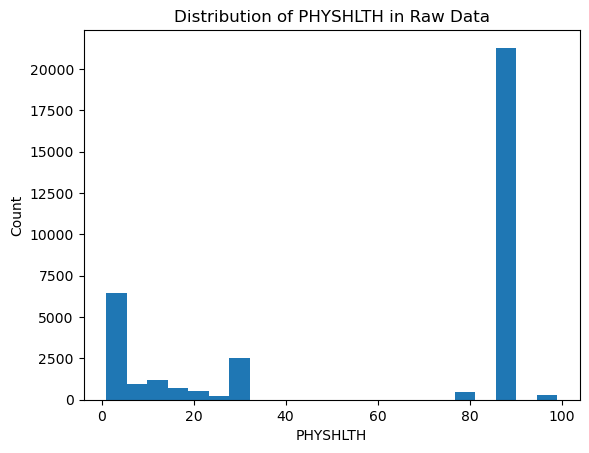

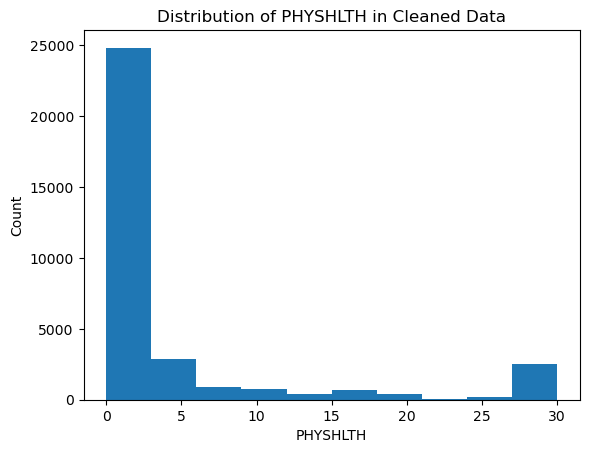

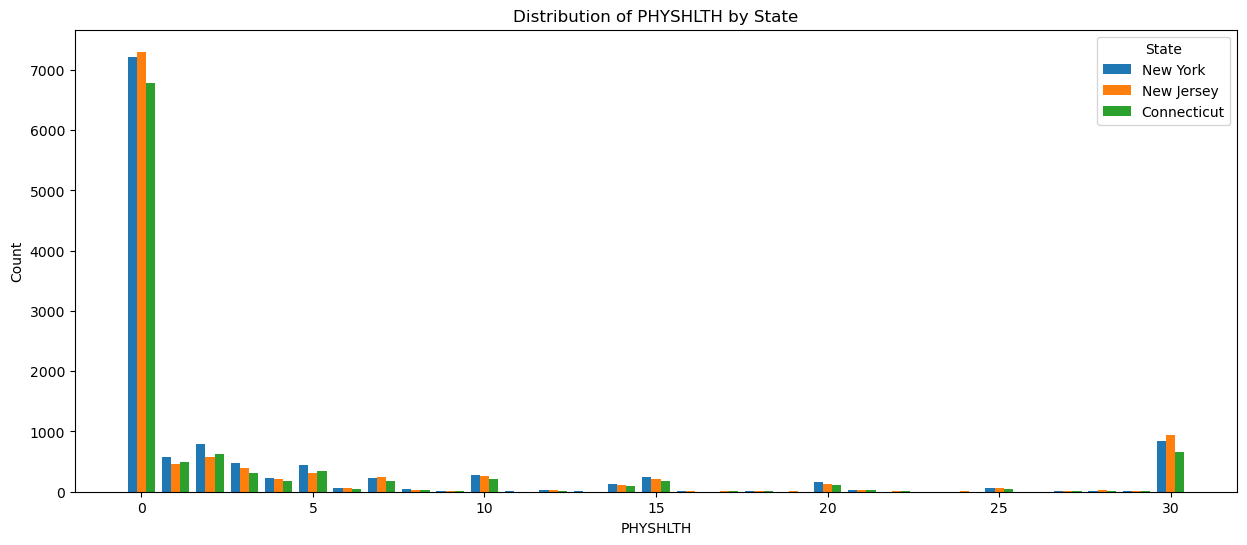

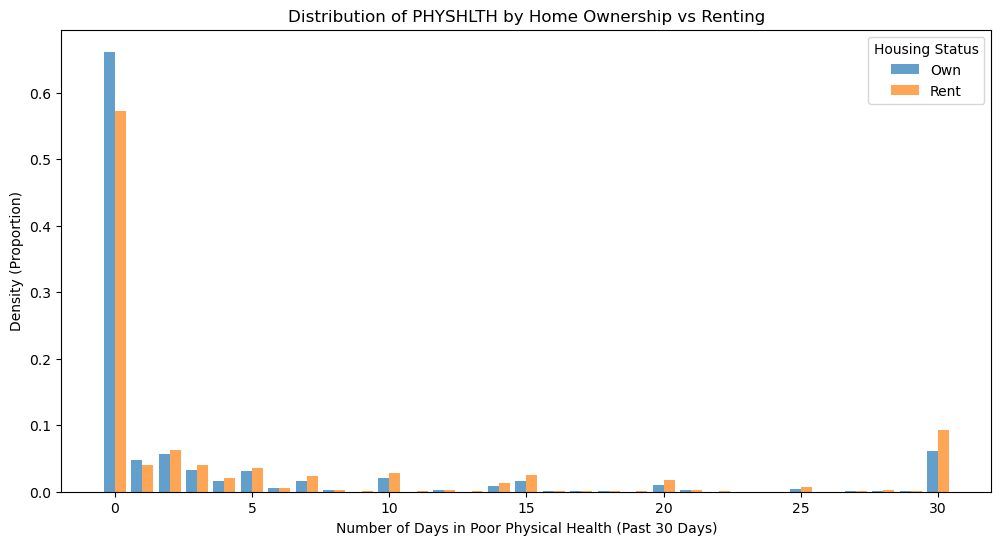

In [31]:
# Separate PHYSHLTH values by housing status
own = df.loc[df["RENTHOM1"] == "Own", "PHYSHLTH"]
rent = df.loc[df["RENTHOM1"] == "Rent", "PHYSHLTH"]

# Plot histogram with density=True
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(
    [own, rent],
    label=["Own", "Rent"],
    bins=range(32),   # 0–31 days
    align="left",
    density=True,     # show proportion instead of raw count
    alpha=0.7
)

ax.set_xlabel("Number of Days in Poor Physical Health (Past 30 Days)")
ax.set_ylabel("Density (Proportion)")
ax.set_title("Distribution of PHYSHLTH by Home Ownership vs Renting")
ax.legend(title="Housing Status")
plt.show()

Then run this code to find the averages:

In [32]:
# Run this cell without changes
df.groupby("RENTHOM1")["PHYSHLTH"].mean()

RENTHOM1
Own     3.531213
Rent    5.197970
Name: PHYSHLTH, dtype: float64

Now, interpret the plot and averages. Does it seem like there a difference in the number of unhealthy days between those who rent their homes and those who own their homes? How does this compare to the distributions by state?

In [33]:
# Replace None with appropriate text
"""
Yes, there appears to be a difference. Renters generally report a higher number of unhealthy days compared to owners, as seen by the renter distribution being slightly shifted toward the right. On average, renters experience more days of poor physical health than owners. 
Compared to the distributions by state, the difference between renters and owners seems more pronounced. While the state-level differences were relatively small (around 0.7 days between Connecticut and New Jersey), the gap between renters and owners is larger and more consistent. This suggests that housing status may be a stronger predictor of physical health outcomes than state of residence.
"""

'\nYes, there appears to be a difference. Renters generally report a higher number of unhealthy days compared to owners, as seen by the renter distribution being slightly shifted toward the right. On average, renters experience more days of poor physical health than owners. \nCompared to the distributions by state, the difference between renters and owners seems more pronounced. While the state-level differences were relatively small (around 0.7 days between Connecticut and New Jersey), the gap between renters and owners is larger and more consistent. This suggests that housing status may be a stronger predictor of physical health outcomes than state of residence.\n'

Now, choose and execute an appropriate statistical test. Make sure you describe why you chose the test, the null and alternative hypotheses, and what the result of the test means.

In [34]:
from scipy.stats import ttest_ind

# Extract groups
own = df.loc[df["RENTHOM1"] == "Own", "PHYSHLTH"]
rent = df.loc[df["RENTHOM1"] == "Rent", "PHYSHLTH"]

# Perform independent samples t-test
t_stat, p_value = ttest_ind(own, rent, nan_policy="omit")

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a statistically significant difference in the mean number of unhealthy days between owners and renters.")
else:
    print("Fail to reject the null hypothesis: No significant difference in the mean number of unhealthy days between owners and renters.")

T-statistic: -16.435805439672
P-value: 1.878839256394904e-60
Reject the null hypothesis: There is a statistically significant difference in the mean number of unhealthy days between owners and renters.


## 4. Describe the Relationship between Chronic Sickness and Nicotine Use

Once again, this will require some preparation before we can run the statistical test. Create a new column `NICOTINE_USE` with 1 representing someone who uses or has used nicotine in some form, and 0 representing someone who hasn't.

We define nicotine use as:

* Answered `Yes` to the `SMOKE100` question (*Have you smoked at least 100 cigarettes in your entire life?*, page 43), OR
* Answered `Every day` or `Some days` to the `USENOW3` question (*Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?*, page 46), OR
* Answered `Yes` to the `ECIGARET` question (*Have you ever used an e-cigarette or other electronic vaping product, even just one time, in your entire life?*, page 46)

If a record matches one or more of the above criteria, `NICOTINE_USE` should be 1. Otherwise, `NICOTINE_USE` should be 0. Go ahead and keep all of the "Don't know" or "Refused" answers as 0.

In [35]:
# Create NICOTINE_USE column
df["NICOTINE_USE"] = (
    (df["SMOKE100"] == 1) |                        # Yes to smoked 100 cigarettes
    (df["USENOW3"].isin([1, 2])) |                # Every day (1) or Some days (2) for smokeless tobacco
    (df["ECIGARET"] == 1)                          # Yes to e-cigarette use
).astype(int)                                     # Convert boolean True/False to 1/0

# Check distribution
df["NICOTINE_USE"].value_counts(normalize=True)

# Look at the distribution of values
df["NICOTINE_USE"].value_counts(normalize=True)

NICOTINE_USE
0    0.563036
1    0.436964
Name: proportion, dtype: float64

This time, let's treat health status as a categorical variable. We'll say that a "chronically sick" person is a person who reports that their physical health was not good for 15 or more out of the past 30 days. (This is a simplification but it will work for this analysis.)

In the cell below, create a new column of `df` called `CHRONIC`, which is 0 for records where `PHYSHLTH` is less than 15, and 1 for records where `PHYSHLTH` is 15 or more.

In [36]:
# Create CHRONIC column: 1 if PHYSHLTH >= 15, else 0
df["CHRONIC"] = (df["PHYSHLTH"] >= 15).astype(int)

# Check the distribution
df["CHRONIC"].value_counts()

# View the distribution of the newly-created column
df["CHRONIC"].value_counts()

CHRONIC
0    28246
1     3688
Name: count, dtype: int64

Now we can view the crosstabs for these two categorical variables, as well as display their distributions:

In [37]:
# Run this cell without changes
contingency_table = pd.crosstab(index=df["CHRONIC"], columns=df["NICOTINE_USE"])
contingency_table

NICOTINE_USE,0,1
CHRONIC,,
0,16332,11914
1,1648,2040


In [38]:
# Run this cell without changes

no_nicotine_use = df.loc[df["NICOTINE_USE"] == 0, "CHRONIC"]
nicotine_use = df.loc[df["NICOTINE_USE"] == 1, "CHRONIC"]

fig, ax = plt.subplots()

ax.hist(
    x=[no_nicotine_use, nicotine_use],
    label=["No Nicotine Use", "Nicotine Use"],
    bins=[0,1,2],
    align="left"
)

ax.set_ylabel("Count")
ax.set_xticks([0,1])
ax.set_xticklabels(["Not Chronically Sick", "Chronically Sick"])
ax.set_title("Distribution of Chronic Sickness by Nicotine Use")

ax.legend();

Once again, it appears that there is a difference in health outcomes between these categories. In the cell below, select an appropriate statistical test, describe the null and alternative hypotheses, execute the test, and interpret the result.

In [39]:
# Create CHRONIC column: 1 if PHYSHLTH >= 15, else 0
df["CHRONIC"] = (df["PHYSHLTH"] >= 15).astype(int)

# Check the distribution
df["CHRONIC"].value_counts()

CHRONIC
0    28246
1     3688
Name: count, dtype: int64

## 5. Choose Your Own Question

Now that you have investigated physical health and chronic sickness and their relationships with state, home ownership, and nicotine use, you will conduct a similar investigation with variables of your choosing.

Select an independent variable based on looking at the information in the data dictionary, and perform any additional transformations needed to use it in an analysis. Then set up, execute, and interpret a statistical test that addresses the relationship between that independent variable and `PHYSHLTH`.

(There is no solution branch for this question, and feel free to move on if you have already spent more than 1.5 hours on this lab.)

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Optional: drop missing values for GENHLTH
df_sub = df[df["GENHLTH"].notna()].copy()

# Fit ANOVA model
formula = 'PHYSHLTH ~ C(GENHLTH)'
lm = ols(formula, df_sub).fit()
anova_results = sm.stats.anova_lm(lm)
print(anova_results)

# Interpretation
group_means = df_sub.groupby("GENHLTH")["PHYSHLTH"].mean()
print("\nMean PHYSHLTH by General Health Rating:\n", group_means)

                 df        sum_sq        mean_sq            F  PR(>F)
C(GENHLTH)      6.0  8.271035e+05  137850.579042  2979.568055     0.0
Residual    31927.0  1.477112e+06      46.265290          NaN     NaN

Mean PHYSHLTH by General Health Rating:
 GENHLTH
1.0     0.902211
2.0     1.513654
3.0     3.289271
4.0    10.998751
5.0    22.946953
7.0     7.111111
9.0     6.128205
Name: PHYSHLTH, dtype: float64


## Conclusion

Congratulations, another cumulative lab down! In this lab you practiced reading a data dictionary, performing various data transformations with pandas, and executing statistical tests to address business questions.